<a href="https://colab.research.google.com/github/kvanhemmen/WC-club-performance/blob/master/Analyzing_the_Relationship_Between_Player_Performance_in_International_Football_and_Club_Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <h1> Analyzing the Relationship Between Player Performance in International Football and Club Football</h1> </center>
<center><h4>Milan Ghosh and Kees van Hemmen</h4></center>


<hr style="height:2px; border:none; color:black; background-color:black;">

#### Executive Summary:

In this project, we endeavored to determine whether professional footballers (soccer players) in Europe's top leagues that perform at a high level in International Competitions (like the World Cup and European Championships) continue to perform well for their club teams after said tournaments. We did this because European clubs spend millions on high performing international tournament players each summer, and these purchases are often mistakes. Our hypothesis was that there will be only a small correlation between goal scoring production in the World Cup and goal scoring production in club competition. We first scraped club player data from six of Europe's top seven leagues from the website understat.com for the 2018-19 season. We then used StatsBomb's online Git Repository to obtain event data for the entire 2018 world cup and passed the event data for shots through an expected goals model. We then used various regression techniques (such as simple regression, ridge regression, and support vector machines) to determine whether players with high goal and expected goal tallies have similarly high tallies in club competition. We visualized our data, ran our regressions, cross validated them, and retuned our hyperparameters to obtain optimal results. Ultimately, the Support Vector Machine gave us our best results and our results supported that the correlation between production at the World Cup and production for one's club is extant yet weak.

<hr style="height:2px; border:none; color:black; background-color:black;">

## Outline
1. <a href='#1'>INTRODUCTION</a>
2. <a href='#2'>METHOD</a>
3. <a href='#3'>RESULTS</a>
4. <a href='#4'>DISCUSSION</a>

<a id="1"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 1. INTRODUCTION

The problem that we wish to address with our project is that European football (soccer) clubs routinely spend millions of Euros on players that perform at a high level in international tournaments like the European championships and the World Cup, yet, despite their high transfer fees, these players do not always perform at the same level for their new clubs once they have been purchased. In the course of this project we hope to determine whether there is a correlation between performance at international tournaments and performance at the club level, and, if so, how strong said correlation is. 

This problem is worthwhile for one, simple, monetary reason: European football clubs spend millions upon millions of Euros (or Pounds) on World Cup standouts every four years, and this is often to no avail. This is particularly the case in the aftermath of the world record transfer of Brazilian Forward Neymar Jr. during the summer of 2017. The world record fee for a player having previously been the £89 million spent on French midfielder Paul Pogba, Neymar's £198 million fee more than doubled that. The market adjusted almost immediately, and European clubs are spending more and more money each summer as a result. Determining whether or not players who play well at international tournaments are safe investments would go a long way towards optimizing club transfer expenditure.

Questions we wish to answer in interpreting our data during this project include: Do the standout players of international tournaments always standout at their clubs in the ensuing season? More specifically, are players that score the most goals or generate the most xG in an international tournament likely to continue to do the same the next season? Are players that score goals in international play likely to contribute to buildup play (measured by xGBuildup and xGChain) more than their non-international-standout counterparts in club play? In terms of technical methology, will Ridge Regression prove to better our model as compared to Simple Regression when considering that the sample sizes of a world cup are so small, and thus so unlikely to generate serious outliers. We hypothesize that high goal tallies and expected goal tallies in international play will have only a weak correlation with high goal and expected goal tallies in club play. We also expect that the correlation with quality in buildup will be even lower. In general, we expect that quality performance in international tournaments is not necessarily indicative of true talent moving forward in club play. We also hypothesize that Ridge Regression will not prove to be a major improvement on Simple Regression in our results.

<a id="2"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 2. METHOD

We have pulled data from two sources. The first source we used is the soccer statistics website understat.com. The understat data features player data such as goals, assists, expected goals, and expected assists for their 2018-2019 club league season. We used data from all six leagues that understat offers: The English Premier League, The Spanish La Liga, the German Bundesliga, the Italian Serie A, the French Ligue 1, and the Russian Premier League. This maximized the size of our dataset while simultaneously ensuring that competition quality was similar (these leagues represent six of the top seven leagues in Europe as per UEFA coefficient).

The second source we pulled our data from was the StatsBomb Git Repository, which offers free event data for every game of the 2018 World Cup in Russia. Using R (their git repository facilitates the language) we pulled the event data and then isolated it to only shot data. Shot data was then converted to expected goals and goals, and finally merged with the club competition data.

The dataset has 2 features (independent variables) and 7 targets (dependent variables). The two independent variables are World Cup goals and World Cup expected goals. Goals are attributed to a player anytime he hits the ball into his opponents net. Expected goals are attributed to a player any time he takes a shot at the opponent goal. For instance, if a player takes a shot that, historically, has a goal probability of 0.04, then his xG total will go up by that amount, regardless of whether or not he scores.

The 7 target variables are as follows: Club Goals/90, Club Shots/90, Club expected Goals/90, Club Non-Penalty Goals/90, Club Non-Penalty Expected Goals/90, Club xGChain/90, and Club xGBuildup/90. Each of these statistics is scaled to a per 90 basis so as to prevent players who played significantly more minutes over a club season from appearing better than they truly are. Shots are attributed to a player any time he shoots at goal. Non-Penalty Goals are attributed to a player any time he scores a goal that is not taken from the penalty spot (which occurs when a player on the same player's team is fouled near the goal in the penalty box). Non Penalty-Expected Goals follow the same principle as expected goals while discounting penalties. xGChain is attributed to a player anytime he makes at least one pass in an attack that leads to a shot. The value that is attributed to said player is equal to the goal probability of said shot. xGBuildup represents the same metric but discounts the player who took the shot and the player who made the pass to the player who took the shot.  

In [0]:
#Understat Data Scraping:
import urllib.request as urllib
from bs4 import BeautifulSoup
import pandas as pd
links = ["Ligue_1/2018", 
         "La_liga/2018",
         "EPL/2018",
         "Bundesliga/2018",
         "Serie_A/2018",
         "RFPL/2018"]
understat = "http://understat.com/league/"
for link in links:
    html = urllib.urlopen(understat+link)
    soup = BeautifulSoup(html.read())
    scripts = soup.find_all("script")
    for tag in scripts:
        if "playersData" in tag.get_text():
            data = tag.get_text()
            data = data[32:-4]
    decoded_data = bytes(data, 'utf-8').decode('unicode_escape')
    df = pd.read_json(decoded_data)
    league, part, year = link.partition("/")
    df.to_csv("res/" + league +"_" + year +".csv")

### 2.2. Variables

Our independent variables are the data from the 2018 World Cup. This data includes goals and expected goals for every player that took part in the tournament as well as one of the six leagues we are analyzing during the ensuing 2018-19 season. We will be calculating the expected goals using the shot data from the World Cup by a shot's location on the field. Our dependent variables are the data from the player's data in their 2018-2019 club league season. This includes shots, goals, non-penalty goals, xG, npxG, xGChain, and xGBuildup. Our feature variables are identical to our independent variables and our target variables are identical to our depedent variables. We are looking to determine the relationship between players who do well in the World Cup and their performance for their club teams the following season.

### 2.3. Data Analysis


Our dataset features continuous data, and so we will be running regressions upon it to obtain insights into the dataset. We intend to predict a player's goalscoring output in club competition (measured in shots/90, goals/90, npG/90, xG/90, and npxG/90) using their goalscoring output in international competition (measured in goals and xG). We also intend to predict a player's quality in possession in club play (measured using xGChain and xGBuildup) using their goalscoring output in international play. We do not yet know which variables we will be running the regressions on specifically as we intend to operate only on those that demonstrate the highest correlations pre-regression.

This is a supervised machine learning problem because we already have the target data that we are attempting to predict. The learning task is both Simple and Multiple Linear Regression, as we will be using both single and multiple feature variables at various points during the regression so as to optimize results. We intend to use the Simple, Ridge, KNeighbors, Lasso, and SVR Regression algorithms to analyze our model. We will use Simple so as to give ourselves a basic regression model that provided a baseline for various improvements. Ridge will be used to smooth outliers, though, given that the World Cup has such a small sample size we don't expect highly problematic outliers (though small samples generate high variance, it is difficult for outlier values to accumulate). KNeighbors will be used to analyze each player based on its most similar players by the involved variables, thus increasing the number of datapoints and therefore model complexity. Lasso will be used to minimize coefficients and prevent the overweighting of outliers. SVR will increase model complexity by executing linear regression numerous times on various axes through the datapoints.

<a id="3"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 3. RESULTS

### 3.1. Data Wrangling


In [0]:
import pandas as pd
git_link = "https://raw.githubusercontent.com/mghosh13/Soccer-Project/master/"
spain = pd.read_csv(git_link + "res/La_liga_2018.csv").drop(columns="Unnamed: 0")
england = pd.read_csv(git_link + "res/EPL_2018.csv").drop(columns="Unnamed: 0")
france = pd.read_csv(git_link + "res/Ligue_1_2018.csv").drop(columns="Unnamed: 0")
germany = pd.read_csv(git_link + "res/Bundesliga_2018.csv").drop(columns="Unnamed: 0")
italy = pd.read_csv(git_link + "res/Serie_A_2018.csv").drop(columns="Unnamed: 0")
russia = pd.read_csv(git_link + "res/RFPL_2018.csv").drop(columns="Unnamed: 0")
spain["League"] = "La Liga"
england["League"] = "English Premier League"
france["League"] = "Ligue 1"
germany["League"] = "Bundesliga"
italy["League"] = "Serie A"
russia["League"] = "Russian Premier League"

In [0]:
club = pd.concat(objs=[spain, england, france, germany, italy, russia])
#Fix the index so it doesn't restart at 0 when new league
club = club.set_index("player_name")
club = club.reset_index()

In [0]:
#Need to find errors in the player_name column
club[club["player_name"].str.contains("&#039")]

,player_name,assists,games,goals,id,key_passes,npg,npxG,position,red_cards,shots,team_title,time,xA,xG,xGBuildup,xGChain,yellow_cards,League
610,N&#039;Golo Kanté,4,36,4,751,46,4,3.033728,M,0,29,Chelsea,3103,3.732989,3.033728,12.484975,17.044977,3,English Premier League
1049,M&#039;Baye Niang,4,29,11,1126,11,9,7.203044,F M S,0,65,Rennes,1799,2.023467,8.723234,1.046131,7.940210,5,Ligue 1
1118,Clinton N&#039;Jie,2,17,3,960,9,3,1.204920,F M S,0,7,Marseille,343,0.981855,1.204920,0.611300,2.724176,0,Ligue 1
1252,Yeni N&#039;Gbakoto,0,15,1,4738,10,1,1.295693,M S,0,18,Guingamp,551,0.520348,1.295693,0.207640,1.352356,0,Ligue 1
1296,Yann M&#039;Vila,1,37,0,732,24,0,0.415423,M,1,14,Saint-Etienne,3264,0.887743,0.415423,10.442372,11.551751,5,Ligue 1
1382,Kevin N&#039;Doram,0,4,0,3657,0,0,0.077560,D S,0,1,Monaco,192,0.000000,0.077560,0.683682,0.683682,2,Ligue 1
1488,Stanley N&#039;Soki,0,12,0,6436,3,0,0.000000,D S,0,0,Paris Saint Germain,698,0.112670,0.000000,2.508031,2.589706,2,Ligue 1
1583,Nathan N&#039;Goumou Minpol,0,1,0,7612,0,0,0.044724,F,0,1,Toulouse,72,0.000000,0.044724,0.062088,0.106811,0,Ligue 1
2209,Danilo D&#039;Ambrosio,5,30,2,1523,34,2,2.154351,D M S,0,16,Inter,2582,5.704240,2.154351,10.012069,14.445313,6,Serie A
2222,Nicolas N&#039;Koulou,0,36,2,3387,4,2,1.179021,D,1,7,Torino,3216,0.084285,1.179021,4.376658,4.376658,6,Serie A


In [0]:
#Find and replace '&#039;' to a single apostrophe
#temp_club = club.replace(to_replace = "*\&#039;*", value = "jk")
import html
html.unescape("M&#039;Baye Niang")
club["player_name"] = club["player_name"].apply(html.unescape)

In [0]:
#Drop a bunch of unnecessary columns: id(specific to understat website), position, yellow and red cards,
club = club.drop(columns = ["id", "position", "red_cards", "yellow_cards", "key_passes", "assists", "xA"])

In [0]:
club.head()

,player_name,games,goals,npg,npxG,shots,team_title,time,xG,xGBuildup,xGChain,League
0,Lionel Messi,34,36,32,22.280909,170,Barcelona,2704,25.997169,10.698799,38.459877,La Liga
1,Luis Suárez,33,21,17,21.421453,112,Barcelona,2832,24.394436,12.378092,36.808274,La Liga
2,Karim Benzema,36,21,18,16.439501,104,Real Madrid,2972,18.669334,8.029115,27.201731,La Liga
3,Iago Aspas,27,20,15,8.753908,70,Celta Vigo,2268,12.470296,5.864634,18.573875,La Liga
4,Cristhian Stuani,32,19,14,10.686555,79,Girona,2736,14.402688,4.393606,12.934034,La Liga


In [0]:
#Standardize columns to be 'per-90 minutes' to see efficiency and allow for players who did not play as many games
# All the statistics that have to be changed to 'per 90 minutes'
stats = ["goals", "npg", "npxG", "shots", "xG", "xGBuildup", "xGChain"]
#Create a new column for the new stats per 90 mins, and then drop the old stats
for stat in stats:
    new_name = stat + " per 90 mins"
    club[new_name] = club[stat] / club["time"] * 90
club = club.drop(columns = stats)
club.head()
#club.to_csv("res/2018Club.csv", index = False)

,player_name,games,team_title,time,League,goals per 90 mins,npg per 90 mins,npxG per 90 mins,shots per 90 mins,xG per 90 mins,xGBuildup per 90 mins,xGChain per 90 mins
0,Lionel Messi,34,Barcelona,2704,La Liga,1.198225,1.065089,0.741598,5.658284,0.865290,0.356099,1.280099
1,Luis Suárez,33,Barcelona,2832,La Liga,0.667373,0.540254,0.680767,3.559322,0.775247,0.393372,1.169754
2,Karim Benzema,36,Real Madrid,2972,La Liga,0.635935,0.545087,0.497831,3.149394,0.565357,0.243143,0.823740
3,Iago Aspas,27,Celta Vigo,2268,La Liga,0.793651,0.595238,0.347377,2.777778,0.494853,0.232724,0.737059
4,Cristhian Stuani,32,Girona,2736,La Liga,0.625000,0.460526,0.351531,2.598684,0.473773,0.144527,0.425462


In [0]:
# World Cup Data was scraped using R and then committed to a CSV. The R file was submitted with the rest of the project
# and can be seen in the blackboard submission for grading.
# The following is the further data cleaning that was done in python.
worldcup = pd.read_csv("https://raw.githubusercontent.com/mghosh13/Soccer-Project/master/res/wcshots%202.csv")
worldcup.head()

,Unnamed: 0,location,type.name,player.name,shot.outcome.name
0,1,"103, 21",Shot,Yasir Gharsan Al Shahrani,Blocked
1,2,"111, 52",Shot,Aleksandr Samedov,Blocked
2,3,"107, 26",Shot,Yuri Zhirkov,Blocked
3,4,"106, 49",Shot,Alan Dzagoev,Blocked
4,5,"112, 47",Shot,Yury Gazinskiy,Goal


In [0]:
coords = worldcup["location"].str.split(", ")
i = 0
for coord in coords:
    coords[i] = coord[0]
    i += 1
worldcup["x"] = coords
coords2 = worldcup["location"].str.split(", ")
k = 0
for coord in coords2:
    coords2[k] = coord[1]
    k += 1
worldcup["y"] = coords2
worldcup.head()

,Unnamed: 0,location,type.name,player.name,shot.outcome.name,x,y
0,1,"103, 21",Shot,Yasir Gharsan Al Shahrani,Blocked,103,21
1,2,"111, 52",Shot,Aleksandr Samedov,Blocked,111,52
2,3,"107, 26",Shot,Yuri Zhirkov,Blocked,107,26
3,4,"106, 49",Shot,Alan Dzagoev,Blocked,106,49
4,5,"112, 47",Shot,Yury Gazinskiy,Goal,112,47


In [0]:
worldcup.drop("location", axis = 1, inplace = True)
worldcup["x"] = worldcup["x"].astype(int)
worldcup["y"] = worldcup["y"].astype(int)

In [0]:
xGvals = []
for date, row in worldcup.iterrows():
    if row["x"] <= 90:
        xGvals.append(0.04)
    elif row["x"] > 90 and row["x"] <= 102 and (row["y"] >= 18 and row["y"] <= 62):
        xGvals.append(0.03)
    elif row["x"] > 90 and row["x"] <= 0 and (row["y"] < 18 or row["y"] > 62):
        xGvals.append(0.02)
    elif row["x"] > 102 and row["x"] <= 114 and (row["y"] >= 34 and row["y"] <= 46):
        xGvals.append(0.13)
    elif row["x"] > 102 and row["x"] <= 114 and (row["y"] < 34 or row["y"] > 46):
        xGvals.append(0.06)
    elif row["x"] > 114 and row["x"] <= 120 and (row["y"] >= 36 and row["y"] <= 44):
        xGvals.append(0.43)
    elif row["x"] > 114 and row["x"] <= 120 and ((row["y"] < 36 and row["y"] >= 34) or (row["y"] <= 46 and row["y"] > 44)):
        xGvals.append(0.17)
    elif row["x"] > 114 and row["x"] <= 120 and ((row["y"] < 34 and row["y"] >= 18) or (row["y"] <= 62 and row["y"] > 46)):
        xGvals.append(0.08)
    else:
        xGvals.append(0.06)
worldcup["xG"] = xGvals

In [0]:
goals = []
for date, row in worldcup.iterrows():
    if row["shot.outcome.name"] == "Goal":
        goals.append(1)
    else:
        goals.append(0)
worldcup["goal"] = goals

In [0]:
worldcup.tail()

,Unnamed: 0,type.name,player.name,shot.outcome.name,x,y,xG,goal
1701,1702,Shot,Mario Mandžukić,Goal,114,43,0.13,1
1702,1703,Shot,Šime Vrsaljko,Off T,78,40,0.04,0
1703,1704,Shot,Ivan Rakitić,Blocked,101,30,0.03,0
1704,1705,Shot,Nabil Fekir,Saved,98,61,0.03,0
1705,1706,Shot,Ivan Rakitić,Off T,90,24,0.04,0


In [0]:
dfToUse = worldcup.groupby(["player.name"]).sum()
dfToUse.drop(["x", "y", "Unnamed: 0"], axis=1, inplace=True)
#dfToUse.to_csv("WorldCupExpectedGoals.csv")

In [0]:
dfToUse.head()

,xG,goal
player.name,,
Aaron Mooy,0.09,0
Abdalla Mahmoud El Said Bekhit,0.10,0
Abdullah Ibrahim Otayf,0.16,0
Achraf Hakimi Mouh,0.06,0
Adem Ljajić,0.06,0


In [0]:
git_link = "https://raw.githubusercontent.com/mghosh13/Soccer-Project/master/"
worldcup = pd.read_csv(git_link + "res/WorldCupExpectedGoals.csv")
club = pd.read_csv(git_link + "res/2018Club.csv")

In [0]:
worldcup.head()

,player.name,xG,goal
0,Aaron Mooy,0.09,0
1,Abdalla Mahmoud El Said Bekhit,0.10,0
2,Abdullah Ibrahim Otayf,0.16,0
3,Achraf Hakimi Mouh,0.06,0
4,Adem Ljajić,0.06,0


In [0]:
club.head()

,player_name,games,team_title,time,League,goals per 90 mins,npg per 90 mins,npxG per 90 mins,shots per 90 mins,xG per 90 mins,xGBuildup per 90 mins,xGChain per 90 mins
0,Lionel Messi,34,Barcelona,2704,La Liga,1.198225,1.065089,0.741598,5.658284,0.865290,0.356099,1.280099
1,Luis Suárez,33,Barcelona,2832,La Liga,0.667373,0.540254,0.680767,3.559322,0.775247,0.393372,1.169754
2,Karim Benzema,36,Real Madrid,2972,La Liga,0.635935,0.545087,0.497831,3.149394,0.565357,0.243143,0.823740
3,Iago Aspas,27,Celta Vigo,2268,La Liga,0.793651,0.595238,0.347377,2.777778,0.494853,0.232724,0.737059
4,Cristhian Stuani,32,Girona,2736,La Liga,0.625000,0.460526,0.351531,2.598684,0.473773,0.144527,0.425462


In [0]:
#Change the names of players in the world cup dataset when they contain the first and last names within the  
i = 0
for data, row in worldcup.iterrows():
    fullname = row["player.name"]
    
    for idata, irow in club.iterrows():
        splitname = irow["player_name"].split(maxsplit = 2)
        first = splitname[0]
        if len(splitname) > 1: 
            last = splitname[1]
        else:
            break      
        
        if first in fullname and last in fullname and fullname.index(first) < fullname.index(last):
            worldcup.loc[i, "player.name"] = irow["player_name"]
            #worldcup[worldcup["player.name"] == fullname]["player.name"] = irow["player_name"]
            print("Changing name to", irow["player_name"])
    i+=1

Changing name to Antoine Griezmann
Changing name to Cristhian Stuani
Changing name to Iago Aspas
Changing name to Lionel Messi
Changing name to Luis Suárez


In [0]:
name_map = {"Šime Vrsaljko":"Sime Vrsaljko", 
            "Łukasz Teodorczyk":"Lukasz Teodorczyk", 
            "Łukasz Piszczek": "Lukasz Piszczek", 
            "İlkay Gündoğan": "Ilkay Gündogan",
            "Óscar Esau Duarte Gaitán": "Óscar Duarte",
            "Éver Maximiliano David Banega": "Éver Banega",
            "Ángel Fabián Di María Hernández": "Ángel Di María",
            "Yūya Ōsako": "Yuya Osako",
            "Yussuf Yurary Poulsen": "Yussuf Poulsen",
            "Yerry Fernando Mina González": "Yerry Mina",
            "Willian Borges da Silva": "Willian",
            "William Silva de Carvalho": "William Carvalho",
            "Yury Gazinskiy":"Yuri Gazinskiy",
            "Thiago Emiliano da Silva": "Thiago Silva",
            "Thiago Alcântara do Nascimento": "Thiago Alcántara",
            "Sung-Yeung Ki": "Ki Sung-yueng",
            "Simon Thorup Kjær": "Simon Kjaer",
            "Sergio Ramos García": "Sergio Ramos",
            "Sergio Leonel Agüero del Castillo": "Sergio Agüero",
            "Sergej Milinković-Savić": "Sergej Milinkovic-Savic",
            "Saîf-Eddine Khaoui": "Saif-Eddine Khaoui",
            "Santiago Arias Naranjo": "Santiago Arias",
            "Samuel Yves Umtiti": "Samuel Yves Umtiti",
            "Rui Pedro dos Santos Patrício": "Rui Patrício",
            "Romelu Lukaku Menama": "Romelu Lukaku",
            "Romain Saïss": "Romain Saiss",            
            "Rodrigo Moreno Machado": "Rodrigo",
            "Rodrigo Bentancur Colmán": "Rodrigo Bentancur",
            "Roberto Firmino Barbosa de Oliveira": "Roberto Firmino",
            "Ricardo Iván Rodríguez Araya": "Ricardo Rodríguez",
            "Raúl Alonso Jiménez Rodríguez": "Raúl Jiménez",
            "Raphaël Varane": "Raphael Varane",
            "Raphaël Adelino José Guerreiro": "Raphael Guerreiro",
            "Raheem Shaquille Sterling": "Raheem Sterling",
            "Radamel Falcao García Zárate": "Falcao",
            "Piotr Zieliński": "Piotr Zielinski",
            "Pione Sisto Ifolo Emirmija": "Pione Sisto",
            "Philippe Coutinho Correia" : "Philippe Coutinho",
            "Paulo Bruno Exequiel Dybala": "Paulo Dybala",
            "Onyinye Wilfred Ndidi": "Wilfred Ndidi",
            "Nicolás Hernán Otamendi": "Nicolás Otamendi",
            "Neymar da Silva Santos Junior": "Neymar",
            "Nemanja Matić": "Nemanja Matic",
            "N\"Golo Kanté": "N'Golo Kanté",
            "Mário Figueira Fernandes": "Mario Fernandes",
            "Michy Batshuayi Tunga": "Michy Batshuayi",
            "Matías Vecino Falero": "Matías Vecino",
            "Mateo Kovačić": "Mateo Kovacic",
            "Martin Braithwaite Christensen": "Martin Braithwaite",
            "Marouane Fellaini-Bakkioui": "Marouane Fellaini",
            "Mario Mandžukić":"Mario Mandzukic",            
            "Mario Gómez García": "Mario Gomez",
            "Marco Asensio Willemsen": "Marco Asensio",
            "Marcelo Vieira da Silva Júnior": "Marcelo",
            "Marcelo Brozović": "Marcelo Brozovic",
            "Manuel Obafemi Akanji": "Manuel Akanji",
            "Manuel Henrique Tavares Fernandes": "Manuel Fernandes",
            "M\"Baye Babacar Niang": "M'Baye Niang",
            "Luka Modrić": "Luka Modric",
            "Luis Jan Piers Advíncula Castrillón": "Luis Advíncula",
            "Luis Fernando Muriel Fruto": "Luis Muriel",
            "Lucas Torreira Di Pascua": "Lucas Torreira",
            "Lucas Rodrigo Biglia": "Lucas Biglia",
            "Lucas Hernández Pi": "Lucas Hernández",
            "Kylian Mbappé Lottin": "Kylian Mbappe-Lottin",
            "Kenneth Josiah Omeruo": "Kenneth Omeruo",
            "Kelechi Promise Iheanacho": "Kelechi Iheanacho",
            "Keita Baldé Diao": "Keita",
            "Juan Guillermo Cuadrado Bello": "Juan Cuadrado",
            "João Mário Mário Naval da Costa Eduardo": "João Mário",
            "José Miguel da Rocha Fonte": "José Fonte",
            "José María Giménez de Vargas": "Giménez",
            "José Martín Cáceres Silva": "Martín Cáceres"}
name_map.update({"Achraf Hakimi Mouh" : "Achraf Hakimi"})
name_map.update({"Adem Ljajić" : "Adem Ljajic"})
name_map.update({"Adrien Sebastian Perruchet Silva" : "Adrien Silva"})
name_map.update({"Aleksandar Mitrović" : "Aleksandar Mitrovic"})
name_map.update({"Alfreð Finnbogason" : "Alfred Finnbogason"})
name_map.update({"Andreas Evald Cornelius" : "Andreas Cornelius"})
name_map.update({"Andrej Kramarić" : "Andrej Kramaric"})
name_map.update({"André Miguel Valente Silva" : "André Silva"})
name_map.update({"Ante Rebić" : "Ante Rebic"})
name_map.update({"Aron Einar Gunnarsson" : "Aron Gunnarsson"})
name_map.update({"Bamidele Alli" : "Dele Alli"})
name_map.update({"Bartosz Bereszyński" : "Bartosz Bereszynski"})
name_map.update({"Bernardo Mota Veiga de Carvalho e Silva" : "Bernardo Silva"})
name_map.update({"Blerim Džemaili" : "Blerim Dzemaili"})
name_map.update({"Breel-Donald Embolo" : "Breel Embolo"})
name_map.update({"Carlos Arturo Bacca Ahumada" : "Carlos Bacca"})
name_map.update({"Carlos Henrique Casimiro" : "Casemiro"})
name_map.update({"Christian Alberto Cueva Bravo" : "Christian Cueva"})
name_map.update({"Christian Dannemann Eriksen" : "Christian Eriksen"})
name_map.update({"Cristiano Ronaldo dos Santos Aveiro" : "Cristiano Ronaldo"})
name_map.update({"Daniel Carvajal Ramos" : "Daniel Carvajal"})
name_map.update({"Daniel Nii Tackie Mensah Welbeck" : "Danny Welbeck"})
name_map.update({"David Josué Jiménez Silva" : "David Silva"})
name_map.update({"Davinson Sánchez Mina" : "Davinson Sánchez"})
name_map.update({"Diego Roberto Godín Leal" : "Diego Godín"})
name_map.update({"Diego Sebastián Laxalt Suárez" : "Diego Laxalt"})
name_map.update({"Diego da Silva Costa" : "Diego Costa"})
name_map.update({"Douglas Costa de Souza" : "Douglas Costa"})
name_map.update({"Edinson Roberto Cavani Gómez" : "Edinson Cavani"})
name_map.update({"Emil Hallfreðsson" : "Emil Hallfredsson"})
name_map.update({"Fabian Lukas Schär" : "Fabian Schär"})
name_map.update({"Faustino Marcos Alberto Rojo" : "Marcos Rojo"})
name_map.update({"Fernando Luiz Rosa" : "Fernandinho"})
name_map.update({"Filip Kostić" : "Filip Kostic"})
name_map.update({"Filipe Luis Kasmirski" : "Filipe Luis"})
name_map.update({"Francisco Román Alarcón Suárez" : "Isco"})
name_map.update({"Fyodor Smolov" : "Fedor Smolov"})
name_map.update({"Gabriel Fernando de Jesus" : "Gabriel Jesus"})
name_map.update({"Gen Shōji" : "Gen Shoji"})
name_map.update({"Gerard Piqué Bernabéu" : "Gerard Piqué"})
name_map.update({"Gonzalo Gerardo Higuaín" : "Gonzalo Higuaín"})
name_map.update({"Gonçalo Manuel Ganchinho Guedes" : "Gonçalo Guedes"})
name_map.update({"Gylfi Þór Sigurðsson" : "Gylfi Sigurdsson"})
name_map.update({"Heung-Min Son" : "Son Heung-Min"})
name_map.update({"Hörður Björgvin Magnússon" : "Hördur Bjorgvin Magnusson"})
name_map.update({"Idrissa Gana Gueye" : "Idrissa Gueye"})
name_map.update({"Ismaïla Sarr" : "Ismaila Sarr"})
name_map.update({"Ivan Perišić" : "Ivan Perisic"})
name_map.update({"Ivan Rakitić" : "Ivan Rakitic"})
name_map.update({"James David Rodríguez Rubio" : "James Rodríguez"})
name_map.update({"Javier Hernández Balcázar" : "Chicharito"})
name_map.update({"Jefferson Agustín Farfán Guadalupe" : "Jefferson Farfán"})
name_map.update({"Jefferson Andrés Lerma Solís" : "Jefferson Lerma"})
name_map.update({"Johan Andrés Mojica Palacio" : "Johan Mojica"})
name_map.update({"Johann Berg Guðmunds­son" : "Johann Berg Gudmundsson"})
name_map.update({"Jordan Brian Henderson" : "Jordan Henderson"})
name_map.update({"Jordi Alba Ramos" : "Jordi Alba"})
name_map.update({"Jorge Resurrección Merodio" : "Koke"})
name_map.update({"José Andrés Guardado Hernández" : "Andrés Guardado"})
name_map.update({"José Ignacio Fernández Iglesias" : "Nacho"})

In [0]:
worldcup = worldcup.replace(to_replace=name_map)

In [0]:
#Need to merge the two datasets on the player_name
worldcup = worldcup.set_index("player.name")
club = club.set_index("player_name")
#Only has players with the exact same name, need to get players that have different names in the different dataframes,
# but are actually the same person
merged = pd.merge(worldcup, club, left_index=True, right_index=True, how = "left")
merged = merged.dropna()
merged = merged.reset_index()
merged = merged.rename(columns = {"index": "name", "xG": "World Cup xG", "goal": "World Cup goals"})
merged.head()

,name,World Cup xG,World Cup goals,games,team_title,time,League,goals per 90 mins,npg per 90 mins,npxG per 90 mins,shots per 90 mins,xG per 90 mins,xGBuildup per 90 mins,xGChain per 90 mins
0,Aaron Mooy,0.09,0,29.0,Huddersfield,2326.0,English Premier League,0.116079,0.077386,0.064198,1.663801,0.093650,0.134715,0.201850
1,Achraf Hakimi,0.06,0,21.0,Borussia Dortmund,1740.0,Bundesliga,0.103448,0.103448,0.087181,1.034483,0.087181,0.434539,0.564247
2,Adem Ljajic,0.06,0,1.0,Torino,27.0,Serie A,0.000000,0.000000,0.223172,6.666667,0.223172,0.367131,0.590303
3,Adnan Januzaj,0.16,1,20.0,Real Sociedad,1243.0,La Liga,0.072405,0.072405,0.187870,2.316975,0.187870,0.144926,0.414385
4,Adrien Silva,0.06,0,2.0,Leicester,86.0,English Premier League,0.000000,0.000000,0.000000,0.000000,0.000000,0.121696,0.121696


The original links to the dataset are as follows:

https://understat.com/

https://github.com/statsbomb/StatsBombR

We have merged all the different league data from understat.com into a single DataFrame and added a league column. We removed several stats that would not be necessary for our research including yellow and red cards, position, and the understat id number. We also scaled the stats so they take into account the number of minutes each player has played. We did this because we deemed that it  would not be good practice to compare the stats of a player with twice as many minutes as another, which was particularly likely in the understat data given the length of a club season as compared to the length of an international tournament. In order to address this, we divided all statistics by their minutes played and then multiplied by 90, to get the stat per 90 minutes.

We also used the StatsBomb API to obtain all the event data from every game of the 2018 World Cup. We then filtered this data so that we had only the shot event data, and created a new csv with only the parts of shot events we cared about (the name of the player who took the shot, whether the shot went in, and the x and y location of the shot on the pitch). We then used this data and passed each shot through our expected goals model, which attributed goal probabilities to each shot based on where on the field the shot was taken from. The shots were then grouped by the player who took the shot in order to obtain goal and expected goal tallies for each player. 

We then merged these two dataframes by player name, obtaining a database of only the players who competed in both the World Cup and one of the six European leagues for which we had data. We encountered a problem here, however, as the StatsBomb database referred to players by their full legal names, and the understat database referred to them by their commonly used names. We attempted to deal with this by changing the StatsBomb player names to the understat player names by changing any player who had both their first and last name appear in their full name in the StatsBomb database altered. This did not fully address the issue, however, as some players, such as Koke of Atletico Madrid and the Spanish national team, have only a one word nickname, and that nickname does not appear anywhere in their full name. This forced us to manually map each players name to their full name using a dictionary and iterate through said dictionary to utilize the full extent of our database. 

The feature selection technique we used was univariate selection. More specifically, we used the f_regression and SelectKBest functions of the sklearn.feature_selection library to choose between our two feature variables so as to obtain optimal results. This can be seen in section 3.4. Scaling was also done midway through Section 3.4.

### 3.2. Data Exploration



In [0]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mghosh13/Soccer-Project/master/res/FinalMergedData.csv")
df.head()

,name,World Cup xG,World Cup goals,games,team_title,time,League,goals per 90 mins,npg per 90 mins,npxG per 90 mins,shots per 90 mins,xG per 90 mins,xGBuildup per 90 mins,xGChain per 90 mins
0,Aaron Mooy,0.09,0,29.0,Huddersfield,2326.0,English Premier League,0.116079,0.077386,0.064198,1.663801,0.093650,0.134715,0.201850
1,Achraf Hakimi,0.06,0,21.0,Borussia Dortmund,1740.0,Bundesliga,0.103448,0.103448,0.087181,1.034483,0.087181,0.434539,0.564247
2,Adem Ljajic,0.06,0,1.0,Torino,27.0,Serie A,0.000000,0.000000,0.223172,6.666667,0.223172,0.367131,0.590303
3,Adnan Januzaj,0.16,1,20.0,Real Sociedad,1243.0,La Liga,0.072405,0.072405,0.187870,2.316975,0.187870,0.144926,0.414385
4,Adrien Silva,0.06,0,2.0,Leicester,86.0,English Premier League,0.000000,0.000000,0.000000,0.000000,0.000000,0.121696,0.121696


In [0]:
df.corr()

Text(0.5, 1.0, 'Expected Goals in the World Cup and how it Compares to npxG in Club Competition')

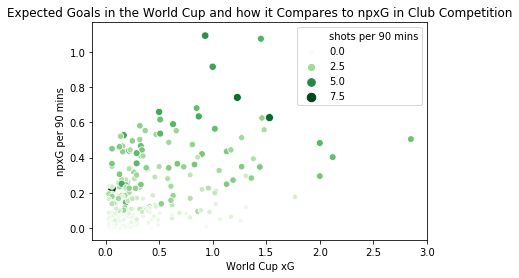

In [0]:
import seaborn as sns
seabornScatter = sns.scatterplot(x="World Cup xG", y="npxG per 90 mins", hue = "shots per 90 mins", size = "shots per 90 mins", palette = "Greens", data=df)
seabornScatter.set_title("Expected Goals in the World Cup and how it Compares to npxG in Club Competition")

Text(0.5, 1.0, 'The Relationship Between Shooting for your Club and Expected Goals for your Country')

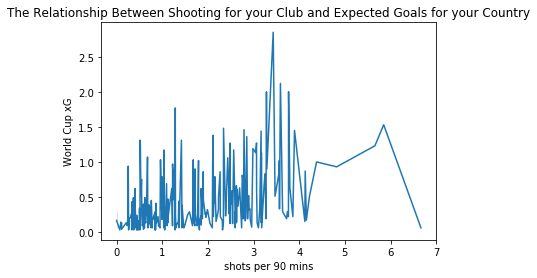

In [0]:
seabornLine = sns.lineplot(x="shots per 90 mins", y = "World Cup xG", data = df)
seabornLine.set_title("The Relationship Between Shooting for your Club and Expected Goals for your Country")

Text(0.5, 1.0, 'Comparing Club Goals and Expected Goals to World Cup Goals and Expected Goals')

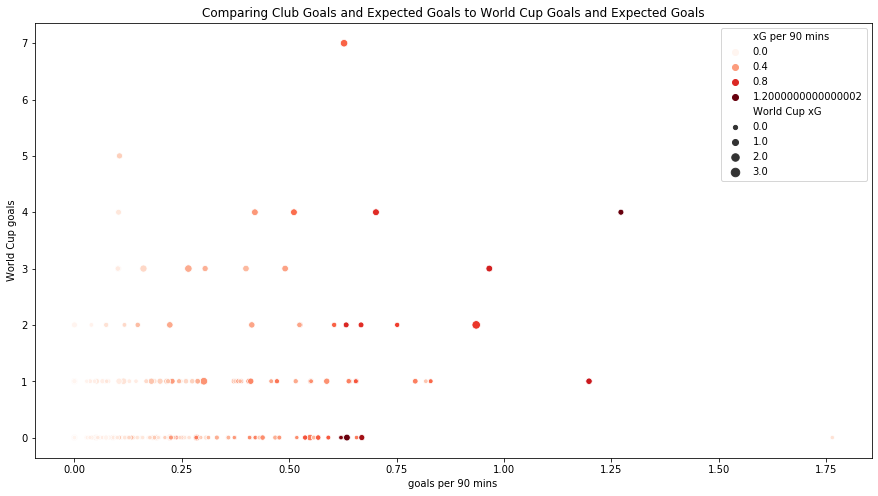

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize = (15, 8))
seabornScatter2 = sns.scatterplot(x = "goals per 90 mins", y = "World Cup goals", hue = "xG per 90 mins",  size = "World Cup xG", data = df, palette = "Reds", legend = "brief", )
seabornScatter2.set_title("Comparing Club Goals and Expected Goals to World Cup Goals and Expected Goals")

[Non-Penalty Expected Goals-World Cup xG Scatterplot](https://drive.google.com/file/d/1y0hjNB4r3iOa9n6t-GOyWz3hYzpTsSKD/view?usp=sharing)

This graph provides useful information because it is a visualization of our strongest correlation across the datasets. Between Non-Penalty Expected Goals per 90 mins in club competition and Expected Goals in the World Cup we found a correlation of nearly 47%. Not only that, but the relationship between shots per 90 mins and World Cup Expected Goals was over 38%, justifying its use as a size and hue modifier. What this visualization shows us is a more detailed profile of the relationship between these variables. Loosely, as World Cup xG increases so does non-penalty xG in club competition, with the number of shots taken in club play increasing roughly with both as well.

[Shots-World Cup xG Lineplot](https://drive.google.com/file/d/1VLQFEZ31kwQoUyq2KVxkKOD8aP4V3-ay/view?usp=sharing)

This graph's purpose is to show in a more isolated visualization how shots per 90 min in Club Competition relates to expected goals in the World Cup. The relationship that it illuminates is a rough correlation between the two where there is a reasonable volume of datapoints. As outliers appear (specifically around 5 shots per 90) we begin to see variation in this trend, but it largely holds true.

[Comparing Goals and xG Across Club and International Competition](https://drive.google.com/file/d/1K47i5HH-Ab6HqiO85ElEzleSUbcUhKO9/view?usp=sharing)

This graph is truly demonstrative of the objective of this project. On the x and y axes is shows World Cup goals graphed to Club goals, but using hue and size gradients it shows how these variables interact with World Cup xG and club xG. Essentially, we find only a loose correlation between the two axes. However, as World Cup xG increases, so do club competition goals. The correlation is loose, however, it tends to support our hypothesis.

### 3.3. Model Construction


In [0]:
# Paired t test

print("H0: Null hypotheses states that there is no statistically significant difference in the mean between expected goals in the World Cup and the non-penalty expected goals")

print("Ha: There is a statistically significant difference between the means of WC xG and npxG per 90 mins.")

from scipy import stats as stats
stat, pval = stats.ttest_rel(a = df["World Cup xG"], b = df["npxG per 90 mins"])
print("\nTest Statistic:", stat)
print("P value:", pval)

print("\nP < .05, therefore we fall within the rejection area.")
print("We reject the null hypothesis and take Ha, which states that there is a difference between the means of WC xG and npxG per 90 mins ")

H0: Null hypotheses states that there is no statistically significant difference in the mean between expected goals in the World Cup and the non-penalty expected goals
Ha: There is a statistically significant difference between the means of WC xG and npxG per 90 mins.

Test Statistic: 8.287496460390757
P value: 6.828672771529788e-15

P < .05, therefore we fall within the rejection area.
We reject the null hypothesis and take Ha, which states that there is a difference between the means of WC xG and npxG per 90 mins 


See 3.4 for training, validation, and testing splits, cross-validation, and machine learning algoritm application and training. We deemed it more intuitive to keep algorithm performance with algorithm execution in our code base.

### 3.4. Model Evaluation


In [0]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mghosh13/Soccer-Project/master/res/FinalMergedData.csv")

df.corr()
df.shape

from scipy import stats
features = df["World Cup xG"]
target = df["npxG per 90 mins"]

r, p = stats.pearsonr(features, target)
print("Correlation Coefficient:" , r , "p-value:" , p)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# function that runs each of the models we utilize over our data
def run_regression(X_train, X_test, y_train, y_test, estimators, ):
  for name, estimator in estimators.items():
    print(name + ":")
    model = estimator.fit(X=X_train, y=y_train)
    print("\tR-squared value for training set: " , r2_score(y_train, model.predict(X_train)))
    print("\tR-squared value for testing set: " , r2_score(y_test, model.predict(X_test)))
    print("\tMean squared error for training set:", mean_squared_error(y_train, model.predict(X_train)))
    print("\tMean squared error for testing set:", mean_squared_error(y_test, model.predict(X_test)))

Correlation Coefficient: 0.4687353157349127 p-value: 2.805894598065374e-15


In [0]:
#Multiple Linear Regression: using multiple features
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


#Uses expected Goals and goals from World Cup as the feature and shots per 90 mins from League data as target
features = df[["World Cup xG", "World Cup goals"]]
target = df["npxG per 90 mins"]


X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 3000)
run_regression(X_train, X_test, y_train, y_test, {"Linear Regression": LinearRegression()})

Linear Regression:
	R-squared value for training set:  0.22091213831652667
	R-squared value for testing set:  0.15975395098448575
	Mean squared error for training set: 0.02735491302283904
	Mean squared error for testing set: 0.038747467461148155


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

estimators = {"Linear Regression" : LinearRegression(), "Ridge" : Ridge(), "Lasso" : Lasso(), "k-Nearest Neighbor" : 
              KNeighborsRegressor(), "Support Vector Machine" : SVR(gamma = "scale")}

In [0]:
#Uses Unscaled data to perform 5 different regression models and calculates r2 score and mean squared error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#Uses expected Goals and goals from World Cup as the feature and shots per 90 mins from League data as target
features = df[["World Cup goals", "World Cup xG"]]
target = df["npxG per 90 mins"]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 3000)
 
#Compare the results of the five different regression algorithms
run_regression(X_train, X_test, y_train, y_test, estimators)

Linear Regression:
	R-squared value for training set:  0.22091213831652667
	R-squared value for testing set:  0.15975395098448575
	Mean squared error for training set: 0.02735491302283904
	Mean squared error for testing set: 0.038747467461148155
Ridge:
	R-squared value for training set:  0.22064757786908085
	R-squared value for testing set:  0.1630300836872608
	Mean squared error for training set: 0.027364202126655295
	Mean squared error for testing set: 0.0385963904695361
Lasso:
	R-squared value for training set:  0.0
	R-squared value for testing set:  -0.031604338367153595
	Mean squared error for training set: 0.03511146093808962
	Mean squared error for testing set: 0.04757184586645109
k-Nearest Neighbor:
	R-squared value for training set:  0.41296916049710153
	R-squared value for testing set:  -0.1703308271252575
	Mean squared error for training set: 0.020611510390659976
	Mean squared error for testing set: 0.05396913879683977
Support Vector Machine:
	R-squared value for training se

In [0]:
#Preprocess data: 
#Scale the features data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


features = df[["World Cup xG"]]
target = df["npxG per 90 mins"]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 3000)


scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
#Compare the results of the five different regression algorithms
run_regression(X_train_scaled, X_test_scaled, y_train, y_test, estimators)

Linear Regression:
	R-squared value for training set:  0.216509035961701
	R-squared value for testing set:  0.19809919575423107
	Mean squared error for training set: 0.02750951237917691
	Mean squared error for testing set: 0.03697919836217851
Ridge:
	R-squared value for training set:  0.21022608670104148
	R-squared value for testing set:  0.17847095981046868
	Mean squared error for training set: 0.027730115906718558
	Mean squared error for testing set: 0.03788434327115103
Lasso:
	R-squared value for training set:  0.0
	R-squared value for testing set:  -0.031604338367153595
	Mean squared error for training set: 0.03511146093808962
	Mean squared error for testing set: 0.04757184586645109
k-Nearest Neighbor:
	R-squared value for training set:  0.41122519490722564
	R-squared value for testing set:  0.012167453228316805
	Mean squared error for training set: 0.020672743570346274
	Mean squared error for testing set: 0.04555333465470682
Support Vector Machine:
	R-squared value for training se

In [0]:
#Now we use Univariate Feature Selection to determine the feature with the higher relationship with our target data
#This is Simple Linear Regression because we choose to use only 1 feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

features = df[["World Cup xG", "World Cup goals"]]
target = df["npxG per 90 mins"]

#Transform the features data to only include the best features
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
select = SelectKBest(score_func = f_regression, k = 1)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)

print("Original results:")
run_regression(X_train, X_test, y_train, y_test, estimators)

print("\nWith feature selection:")
run_regression(X_train_selected, X_test_selected, y_train, y_test, estimators)

Original results:
Linear Regression:
	R-squared value for training set:  0.22091213831652667
	R-squared value for testing set:  0.15975395098448575
	Mean squared error for training set: 0.02735491302283904
	Mean squared error for testing set: 0.038747467461148155
Ridge:
	R-squared value for training set:  0.22064757786908074
	R-squared value for testing set:  0.1630300836872608
	Mean squared error for training set: 0.0273642021266553
	Mean squared error for testing set: 0.0385963904695361
Lasso:
	R-squared value for training set:  0.0
	R-squared value for testing set:  -0.031604338367153595
	Mean squared error for training set: 0.03511146093808962
	Mean squared error for testing set: 0.04757184586645109
k-Nearest Neighbor:
	R-squared value for training set:  0.41296916049710153
	R-squared value for testing set:  -0.1703308271252575
	Mean squared error for training set: 0.020611510390659976
	Mean squared error for testing set: 0.05396913879683977
Support Vector Machine:
	R-squared value

In the above model performance tests, we began by running a Simple Regression on our training and testing sets, and analyzing its performance using an R-squared test and a Mean squared error analysis. We first did this in the form of Multiple Linear Regression, using both of our features to best predict our non-penalty expected goals in club competition. Our results for this phase, a 0.21 and 0.16 values for our R-squared values on training and testing sets respectively, indicate a weak yet present correlation between our features and target data. Mean squared error scores of 0.027 and 0.039 each also indicate that the model is finding the line of best fit effectively, yet a higher testing set score indicates slight overfitting. 

We then moved on to test the rest of our regression algorithms this time using only World Cup xG to predict Club Competition npxG. Each of our decisions when selecting feature and target variables manually for our regressions was educated by correlation values found by calling the Pandas DataFrame method .corr() on our DataFrame. When we ran each of the Linear Regression, Ridge Regression, Lasso Regression, K-Nearest Neighbor Regression, and Support Vector Machine Regressions using these feature and target variables we got very different results. Lasso and K-Nearest Neighbor Regression returned very poor results, with the Lasso scoring 0.0 on our training set for R-squared and a negative value on our testing set. Essentially, it failed to accurately predict any target variables in our training set and had a negative relationship between its predictions and the target values in the testing set. This is obviously not optimal performance and the mean-squared error values it registered indicate minimal room for improvement via hyperparameter tuning. K-Nearest Neighbor registered different, yet equally problematic results, as it had an r-squared value of 0.40 on our training set, but a 0.03 score on our testing set. This, paired with a mean-squared error on the testing set of nearly twice the training set, indicate overfitting. Far better results came from the use of Linear Regression, Ridge Regression, and the Support Vector Machine Algorithms. Each of these algorithms had r-squared values over .20 for training, and the Support Vector Machine had an r-squared over .20 for its testing set as well. This indicates that going forward the Support Vector Machine is likely to provide us with optimal results, as its mean-squared error differential indicated slight overfitting, but nothing that could not be amended via hyperparameter tuning.

 Our results after scaling our data were practically identical for each algorithm, with the exception of Ridge Regression which saw a slight decrease in performance on its testing set.

 We then ran our algorithms one more time and used univariate selection to optimize which feature variable we were using so as to obtain the best results for our model. Using the f_regression function of the sklearn.feature_selection library univariate selection lead us to using just the World Cup xG feature, as opposed to the World Cup goal feature. This did not improve our model's performance, as we had manually selected xG as our feature variable previously. Though some improvement can be seen in the numerical results, this shows only the improvement between using both goals and xG to using just xG. 

 On the issue of hypothesis testing, what we did to analyze our hypothesis was encouraging. However, it is important to understand that our methodology was in some ways flawed. Though we successfully reject the null hypothesis when conducting a paired t-test between World Cup xG and Club npxG per 90 mins, this comes with a caveat. T-tests compare averages, and so, despite positive results, we cannot truly say that World Cup xG and Club npxG per 90 mins have a statistically demonstrable relationship, because they are measured on a different scale. Club npxG/90 is a rate statistic, whereas World Cup xG is an aggregate statistic. Despite this flaw, we did produce a hypothesis, and we wanted to provide some form of hypothesis testing. We were limited to a paired t-test because our experiment is a between-subjects design that has both 1 and 2 independent variables at different points during the regression analysis. This means that the only alternative would be a repeated measures ANOVA, but this was not an option either because our independent variable is not categorical, but rather continuous.


### 3.5. Model Optimization


In [0]:
#Grid search using SVR and modifying the C regulization parameter
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = df[["World Cup xG"]]
target = df["npxG per 90 mins"]


from sklearn.model_selection import GridSearchCV
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVR(gamma="scale"), param_grid, cv = 5)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
grid_search.fit(X=X_train, y=y_train)


#the performance of the best found parameters on the test set
print("Test set score: ", grid_search.score(X_test, y_test))
print()

#result of grid search
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Test set score:  0.1517813029099706

Best parameters:  {'C': 100}
Best cross-validation score:  0.14731644796073814


Because we found that SVM (a.k.a. SVR) was our best performing algorithm, we engaged in hyperparameter tuning for the algorithm using grid-search. We did this because we saw that our mean-squared error values indicated slight overfitting. This optimizes the C regularization parameter, thus effecting how the data is scaled before it is processed. After applying grid search, we saw a slight drop off in our training r-squared value, but a correspondingly small decrease in the difference between our mean-squared error values, indicating a slight decrease in overfitting.

### 3.6. Model Testing


In [0]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = df[["World Cup xG"]]
target = df["npxG per 90 mins"]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)

model = SVR(C = 100).fit(X=X_train, y = y_train)

print("\tR-squared value for training set: " , r2_score(y_train, model.predict(X_train)))
print("\tR-squared value for testing set: " , r2_score(y_test, model.predict(X_test)))    
print("\tMean squared error for training set:", mean_squared_error(y_train, model.predict(X_train)))
print("\tMean squared error for testing set:", mean_squared_error(y_test, model.predict(X_test)))

	R-squared value for training set:  0.2405647779927329
	R-squared value for testing set:  0.21232487500937547
	Mean squared error for training set: 0.026664880132517575
	Mean squared error for testing set: 0.03632318927448655


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


<a id="4"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">

## 4. DISCUSSION


In analyzing our data we first used our DataFrame to test correlation between various different variables. We used this information to educate our decision on which variables to use when visualizing our data. These two factors were then taken into account so as to pick a target variable. Then, feature selection was used to select features, and we in turn ran our regressions. The regressions we ran are as follows: Linear Regression, Ridge Regression, K-Nearest Neighbors Regression, Lasso Regression, and SVR Regression. Once we ran our regressions we engaged in hyper parameter tuning so as to optimize our algorithms. We then re ran our tuned algorithm and obtained our results.

As stated above, in sections 3.4, 3.5, and 3.6 the Linear Regression, Ridge Regression, K-Nearest Neighbors, Lasso Regression, and SVR algorithms were compared to one another. The SVR algorithm revealed the best results because it had both the highest r-squared value for training and testing and was roughly tied for joint-lowest difference in mean-squared error between the training and testing sets. This algorithm should be used for our predictive model. 

As mentioned in our analysis of our hypothesis tests, we did find a significant relationship between World Cup xG and Club Competition npxG per 90. If we were to ignore the inherent flaw in this methodology, it would show us that it is in fact the case that there is a weak relationship between World Cup xG and Club Competition npxG per 90. Essentially: players who produce high expected goal values at international tournaments may be expected to produce high non-penalty expected goals for their club teams, but it is nowhere near a sure thing. This is logical because, though the best players in a World Cup are more likely to be the best players for their clubs, international tournaments have small sample sizes and therefore high variance. This would seem to refute the logic of such teams as Real Madrid and Napoli, who purchased James Rodriguez and Hirving Lozano, respectively, after they had standout World Cup performances. That is not to say, however, that these purchases were unequivocally mistakes. It is to say, rather, that perhaps greater thought and caution should go into the purchase of international tournament stars going forward.

In future work, there are a couple of goals that we have set our for ourselves. Primarily, we would like to have a larger dataset to work with. Not only is it difficult to get significant results with a dataset of just over 200 players, but it is also difficult to analyze player performance using only xG and goals as feature variables. Player performance at the World Cup is not just characterized by goal scoring prowess, and having possession based statistics for the World Cup like xGChain and xGBuildup (which we may have had the capacity to calculate given more time) would have made our analysis far more robust. Having fewer features limited the benefits that univariate feature selection may have afforded us. Minutes played would also make our analysis superior, as we may have put our World Cup statistics on a per 90 basis as well. More tournaments (like the 2016 European Championships and the 2014 World Cup) may also have improved our dataset, as well as more club seasons.

<a id="5"></a>
<hr style="height:2px; border:none; color:black; background-color:black;">